# Notes

The script pretty much replicates the table below. The first difference is that only one set of factors is tested, therefore the table would only have one group of columns, for instance 2x3 if the user passes this set of factors. The second difference is that only a model with all the factors passed is estimated (no permutations), therefore the table below would only include une row for each panel with the list of all the factors, for instance only HML RMW CMA for each panel in the table below.

The script contains all the basic elements, the user is free to wrap the script into an outer loop on a list of factors sets, and an inner loop to test permutation with subsets of factors for each set of factor.

The user can pass a set of factors and a collection of multiple sets of test assets, similar to the table below (there 6 panels). The script test the set of factor against all the test asset sets and calculate different metrics (the one in the table below plus those used in Fama and French (2016)).

The output contains on each row the result of one regression (one portfolios regressed on the set of factors). Part of the columns dynamically will contain the name of the factors passed by the user (the factors coefficients, the factors pv, and the factors t-stat). For instance the columns would be:
- reg_n
- test_ptf_set_n
- obs
- nfactors
- formed_on
- ptf_n
- test_ptf
- factors_list
- Mkt-RF
- SMB
- HML
- CMA
- RMW
- XMY
- Mkt-RF_pv
- SMB_pv
- HML_pv
- CMA_pv
- RMW_pv
- XMY_pv
- Mkt-RF_tstat
- SMB_tstat
- HML_tstat
- CMA_tstat
- RMW_tstat
- XMY_tstat
- alpha
- alpha_pv
- alpha_tstat
- R2
- avg_R2
- Adj_R2
- avg_Adj_R2
- GRS
- GRS_pVal
- A|a|
- A|a|/A|r|
- A(a^2)/A(r^2)
- As^2(a)/A(a^2)]

Table 5 from Fama and French (2015)

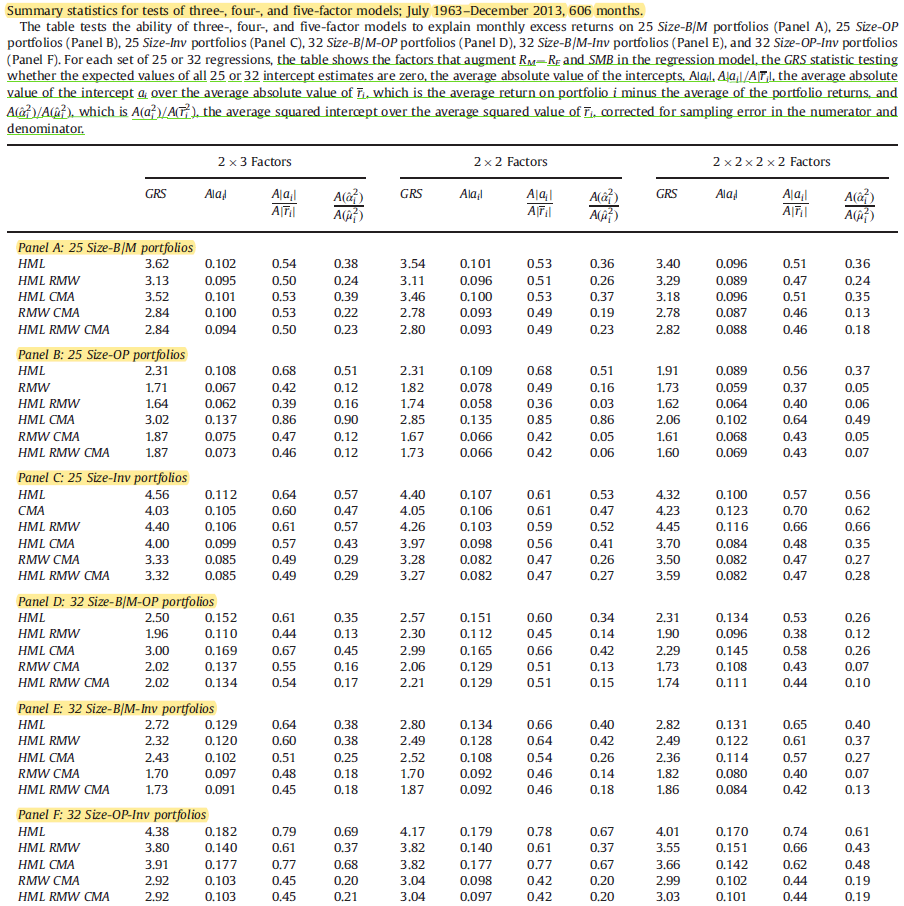

## References

The GRS function has been adpted from https://github.com/anusar80/GRS<br>
Notes about GRS test are in https://faculty.chicagobooth.edu/eugene.fama/teaching/Reading%20List%20and%20Notes/GRS.pdf<br>
References for the F-test are in https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html<br>
References for the regression diagnostics are in:
- https://regressors.readthedocs.io/en/latest/usage.html
- https://regressors.readthedocs.io/en/latest/_modules/regressors/stats.html#coef_pval
- https://regressors.readthedocs.io/en/latest/_modules/regressors/stats.html#coef_se


Reference papers:
- Fama, E. F., & French, K. R. (2021). Common risk factors in the returns on stocks and bonds (pp. 392-449). University of Chicago Press.
- Fama, E. F., & French, K. R. (2015). A five-factor asset pricing model. Journal of financial economics, 116(1), 1-22.
- Fama, E. F., & French, K. R. (2016). Dissecting anomalies with a five-factor model. The Review of Financial Studies, 29(1), 69-103.

# Imports and Setups

In [101]:
# !jupyter nbconvert --to script Asset_pricing_test.ipynb

In [102]:
import pandas as pd

import numpy as np
from numpy.linalg import inv
from numpy import newaxis
import glob
import dateutil
import datetime as dt
import scipy.optimize
import matplotlib as plot
from pathlib import Path
from os import listdir
import os
from os.path import isfile, join
import chardet
from csv import reader
import numpy as np
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
# from regressors import stats
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import warnings
from itertools import combinations

idx = pd.IndexSlice

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Script

## Script Configuration

Asset pricing test dates

In [103]:
test_startdate=pd.to_datetime('19630731')
test_enddate=pd.to_datetime('20201231')

## Functions

In [104]:
def adj_r2_score(clf, X, y):
    """Calculate the adjusted :math:`R^2` of the model.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].

    Returns
    -------
    float
        The adjusted :math:`R^2` of the model.
    """
    n = X.shape[0]  # Number of observations
    p = X.shape[1]  # Number of features
    r_squared = metrics.r2_score(y, clf.predict(X))
    return 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))

def coef_se(clf, X, y):
    """Calculate standard error for beta coefficients.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].

    Returns
    -------
    numpy.ndarray
        An array of standard errors for the beta coefficients.
    """
    n = X.shape[0]
    X1 = np.hstack((np.ones((n, 1)), np.matrix(X)))
    se_matrix = scipy.linalg.sqrtm(
        metrics.mean_squared_error(y, clf.predict(X)) *
        np.linalg.inv(X1.T * X1)
    )
    return np.diagonal(se_matrix)


def coef_tval(clf, X, y):
    """Calculate t-statistic for beta coefficients.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].

    Returns
    -------
    numpy.ndarray
        An array of t-statistic values.
    """
    a = np.array(clf.intercept_ / coef_se(clf, X, y)[0])
    b = np.array(clf.coef_ / coef_se(clf, X, y)[1:])
    return np.append(a, b)


def coef_pval(clf, X, y):
    """Calculate p-values for beta coefficients.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].

    Returns
    -------
    numpy.ndarray
        An array of p-values.
    """
    n = X.shape[0]
    t = coef_tval(clf, X, y)
    p = 2 * (1 - scipy.stats.t.cdf(abs(t), n - 1))
    return p

In [105]:
def GRS(alpha, resids, mu):
    # GRS test statistic
    # N assets, L factors, and T time points
    # alpha is a Nx1 vector of intercepts of the time-series regressions,
    # resids is a TxN matrix of residuals,
    # mu is a TxL matrix of factor returns
    T, N = resids.shape
    L = mu.shape[1]
    mu_mean = np.nanmean(mu, axis=0)
    cov_resids = np.matmul(resids.T, resids) / (T-L-1)
    cov_fac = np.matmul(np.array(mu - np.nanmean(mu, axis=0)).T, np.array(mu - np.nanmean(mu, axis=0))) / T-1
    GRS = (T / N) * ((T - N - L) / (T - L - 1)) * ((np.matmul(np.matmul(alpha.T, inv(cov_resids)), alpha)) / (1 + (np.matmul(np.matmul(mu_mean.T, inv(cov_fac)), mu_mean))))
    pVal = scipy.stats.f.sf(GRS, dfn=N, dfd=(T - N - L)) 
    return GRS, pVal

In [106]:
#This function regress the ptf test on the selected factors and save all the info
def asset_pricing_test_ptf_set_input():
    
    #read the names of factors passed
    factors_files_name_list=factors_to_use.columns.str.split('_').str[0].to_list()
    
    alpha=np.empty([0,1])
    alpha_pv=np.empty([0,1])
    alpha_tStat=np.empty([0,1])
    alpha_se=np.empty([0,1])
    
    R2=np.empty([0,1])
    adj_R2=np.empty([0,1])

    resids=np.empty([n_obs,0])

    coef=np.empty([0,n_tot_factors])
    coef_pv=np.empty([0,n_tot_factors])
    coef_tStats=np.empty([0,n_tot_factors])

    test_ptf=np.empty([0,1])

    reg_counter=np.empty([0,1])
    for name, values in test_assets_to_use.iteritems():     

        #regression
        reg = LinearRegression().fit(factors_to_use, values)
        pVals=coef_pval(reg, factors_to_use, values)

        tStats=coef_tval(reg, factors_to_use, values)
        se=coef_se(reg, factors_to_use, values)

        alpha=np.vstack([alpha, reg.intercept_])
        alpha_pv=np.vstack([alpha_pv, pVals[0]])
        alpha_tStat=np.vstack([alpha_tStat, tStats[0]])
        alpha_se=np.vstack([alpha_se, se[0]])

        R2=np.vstack((R2, reg.score(factors_to_use, values)))
        adj_R2=np.vstack((adj_R2, adj_r2_score(reg, factors_to_use, values)))

        resids=np.hstack((resids, np.array(values - reg.predict(factors_to_use)).reshape(n_obs,1)))

        coef_tmp=np.array([list(reg.coef_)[factors_files_name_list.index(f)] if f in factors_files_name_list else np.nan for f in factors_full_list])
        coef=np.vstack((coef, coef_tmp))

        coef_pv_tmp=[pVals[factors_files_name_list.index(f)+1] if f in factors_files_name_list else np.nan for f in factors_full_list]
        coef_pv=np.vstack((coef_pv, coef_pv_tmp))

        coef_tStats_tmp=[tStats[factors_files_name_list.index(f)+1] if f in factors_files_name_list else np.nan for f in factors_full_list]
        coef_tStats=np.vstack((coef_tStats, coef_tStats_tmp))        

        test_ptf=np.vstack([test_ptf, name])     

    #GRS statistics
    GRS_statistic, GRS_pVal = GRS(alpha, resids, np.array(factors_to_use))

    #average R2
    avg_R2=np.array(np.mean(R2).reshape(1,1))
    
    #average adj R2
    avg_adj_R2=np.array(np.mean(adj_R2).reshape(1,1))

    #average absolute alpha set
    avg_abs_alpha_set=np.array(np.mean(np.absolute(alpha)).reshape(1,1))

    #averge absolute alpha, ptf return ratio
    ri_bar=np.array(test_assets_to_use.mean().transform(lambda x: x -x.mean()))
    avg_abs_alpha_ptf_ratio=np.array(avg_abs_alpha_set/np.mean(np.absolute(ri_bar))).reshape(1,1)

    #averge squared alpha, ptf squared return ratio
    avg_squared_alpha_squared_ptf_ratio=np.array(np.mean(np.power(alpha,2))/np.mean(np.power(ri_bar,2))).reshape(1,1)  
    
    #average alpha sampling error variance, average squared alpha ratio
    avg_alpha_sampling_error_variance_average_squared_alpha_ratio=np.array(np.mean(np.power(alpha_se,2))/np.mean(np.power(alpha,2))).reshape(1,1)
    

    ###########################################################################################################
    #this part of the function is user defined based on the info that want to be saved in the estimations table
    ###########################################################################################################
    
    test_info_cols=['reg_n','test_ptf_set_n','obs','nfactors','formed_on']
    estimations_info_cols=['ptf_n',\
                           'test_ptf',\
                           'factors_list']\
                           +\
                           factors_to_use.columns.to_list()\
                           +\
                           [n+'_pv' for n in factors_to_use.columns.to_list()]\
                           +\
                           [n+'_tstat' for n in factors_to_use.columns.to_list()]\
                           +\
                           ['alpha',\
                           'alpha_pv',\
                           'alpha_tstat',\
                           'R2',\
                           'avg_R2',\
                           'Adj_R2',\
                           'avg_Adj_R2',\
                           'GRS',\
                           'GRS_pVal',\
                           'A|a|',\
                           'A|a|/A|r|',\
                           'A(a^2)/A(r^2)',\
                           'As^2(a)/A(a^2)']
    
    #concatenation regression info
    test_info=pd.DataFrame(np.array([np.nan,test_ptf_set_n,factors_to_use.shape[0],factors_to_use.shape[1],formed_on]).reshape(1,len(test_info_cols)).repeat(n_test_assets, axis=0), columns=test_info_cols)
    
    #concatenation regression estimates    
    estimations_info=pd.DataFrame(np.concatenate([\
                                                     np.arange(1,n_test_assets+1).reshape(n_test_assets,1),\
                                                     test_ptf,\
                                                     np.array(factors_names).reshape(1,1).repeat(n_test_assets, axis=0),\
                                                     coef,\
                                                     coef_pv,\
                                                     coef_tStats,\
                                                     alpha,\
                                                     alpha_pv,\
                                                     alpha_tStat,\
                                                     R2,\
                                                     avg_R2.repeat(n_test_assets, axis=0),\
                                                     adj_R2,\
                                                     avg_adj_R2.repeat(n_test_assets, axis=0),\
                                                     GRS_statistic.repeat(n_test_assets, axis=0),\
                                                     GRS_pVal.repeat(n_test_assets, axis=0),\
                                                     avg_abs_alpha_set.repeat(n_test_assets, axis=0),\
                                                     avg_abs_alpha_ptf_ratio.repeat(n_test_assets, axis=0),\
                                                     avg_squared_alpha_squared_ptf_ratio.repeat(n_test_assets, axis=0),\
                                                     avg_alpha_sampling_error_variance_average_squared_alpha_ratio.repeat(n_test_assets, axis=0)\
                                                  ], axis=1), columns=estimations_info_cols)

    #append regression info and estimates
    estimations_i=pd.concat([test_info, estimations_info], axis=1).replace('nan', np.nan).apply(lambda x: pd.to_numeric(x, downcast='float', errors='ignore'), axis=0)
    decimals = pd.Series(5*np.ones(estimations_i.shape[1]), index=estimations_i.columns).astype(int)
    decimals['GRS_pVal']=20 #round everything to 6 decimals except for GRS_pVal to 20
    estimations_i=estimations_i.round(decimals)
    
    return estimations_i

## Estimation

The factors file must contain the factors organized in columns and the time index along the rows. The file must contain only one set of factors. The user can generalize the script by loading multiple files in a loop and test the them again mulitple set of test assets using this script

In [107]:
test_ptf_set_n=0

#initialize the dataframe that will contain all the dataframes for each factors file
estimations_f=pd.DataFrame()

#factors file reading
factors_file_name="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\factors\\factors_example.csv"
factors_to_use=pd.read_csv(factors_file_name, sep=',', index_col=0)

#filter the dates
factors_to_use=factors_to_use[(pd.to_datetime(factors_to_use.index)>=test_startdate) & (pd.to_datetime(factors_to_use.index)<=test_enddate)]
n_tot_factors=factors_to_use.shape[1]
print("########################################################################################")
print(" read: "+factors_file_name)
print("########################################################################################")

factors_to_use

########################################################################################
 read: G:\My Drive\PhD\Research\Indipendent project\estimated_data\factors\factors_example.csv
########################################################################################


,Mkt-RF,SMB,HML,CMA,RMW,XMY
date,,,,,,
1963-07-31,-0.002574,-0.001141,0.010661,-0.001796,-0.006182,-0.007687
1963-08-31,0.051113,-0.002736,0.022448,-0.008099,-0.000985,-0.000486
1963-09-30,-0.014529,-0.000050,0.003686,0.006060,-0.001332,0.009434
1963-10-31,0.029988,0.027839,0.019497,-0.025518,0.015914,0.011917
1963-11-30,-0.007858,0.005812,0.008133,0.003767,0.007468,0.004172
...,...,...,...,...,...,...
2020-08-31,0.075901,0.015319,-0.017158,-0.011619,0.028451,0.002834
2020-09-30,-0.037979,-0.015824,-0.009038,-0.003895,-0.000674,-0.012288
2020-10-31,-0.020139,0.041916,0.021759,-0.010489,-0.003178,-0.004275


The test asset file can contain multiple set of portfolios to be tested. Each set is identified by the column sort_on, the n-th portfolio of the set is identified by the column ptf_code. The time dimension is indicated by the column date. The column ret contains the returns.

The test assets portfolios must be passed in a file that contains as columns:
- date
- ptf_code
- ret
- sort_on

As it can be seen from the example below, the date is the date of the returns, the ptf_code contains the combination of the sort_on and the number of portfolio in the set, ret is the return, sort_on represent the name of the set of test asset portfolios.

For instance in Fama and French (2015), the 5 factor model is tested against 6 sets of portfolios. 3 sets have each 25 portfolios as a result of a 5x5 double sorts using a pair of measuer on each set, and  3 sets have each 32 portfolios as a result of a 2x4x4 three-way sorts using triplets of measure where one was alwasy size. In other terms in that study the 6 sets were:
- 25 Size-B/M portfolios
- 25 Size-OP portfolios
- 25 Size-Inv portfolios
- 32 Size-B/M-OP portfolios
- 32 Size-B/M-Inv portfolios
- 32 Size-OP-Inv portfolios

For instance in the forst set the column sort_on would contain "Size_bm", and there would be 25 rows, with incremental value from 1 to 25 in the column ptf_code. The 25 rows would have the same date, and the column ret would contain the returns.

In [108]:
#test_assets file reading
test_assets_file_name="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\test_assets\\test_assets_example.csv"
test_assets=pd.read_csv(test_assets_file_name, sep=',', index_col=0).reset_index()

#filter the dates
test_assets=test_assets[(pd.to_datetime(test_assets['date'])>=test_startdate) & (pd.to_datetime(test_assets['date'])<=test_enddate)]

test_assets

,date,ptf_code,ret,sort_on
0,1963-07-31,size1_bm1,-0.002700,size_bm
1,1963-08-31,size1_bm1,-0.002500,size_bm
2,1963-09-30,size1_bm1,-0.002700,size_bm
3,1963-10-31,size1_bm1,-0.002900,size_bm
4,1963-11-30,size1_bm1,-0.002700,size_bm
...,...,...,...,...
172495,2020-08-31,inv5_nf5,0.070680,inv_nf
172496,2020-09-30,inv5_nf5,-0.058581,inv_nf
172497,2020-10-31,inv5_nf5,-0.037810,inv_nf
172498,2020-11-30,inv5_nf5,0.076870,inv_nf


In [109]:
#initialize a list that contains the dataframes named estimations_i
estimations_list=[]

#factors statistics
print("    {} dates, from {} to {}".format(factors_to_use.shape[0],factors_to_use.index.min(),factors_to_use.index.max()))
print("    #############################################################################")

#loop on test assets (variable groups portfolios are formed on)
for formed_on, test_rets in test_assets.groupby('sort_on'):

    #read the test asset set
    test_assets_to_use=test_rets.pivot(index='date', columns='ptf_code', values='ret')
    test_ptf_set_n+=1

    n_obs=factors_to_use.shape[0]
    n_test_assets=test_assets_to_use.shape[1]

    print('            {} on {}'.format(n_test_assets, ', '.join(formed_on.split('_'))))

    factors_names='_'.join(factors_to_use.columns.to_list())

    #run the asset pricing test, compute the statistics and save them
    estimations_list.append(asset_pricing_test_ptf_set_input())

    #concatenate together and append to estimations the single regression estimation results
    estimations_f=pd.concat([estimations_f, pd.concat(estimations_list, axis=0)], axis=0)


#Save into a file the estimation results for each factors file
estimations_f['reg_n']=range(1,estimations_f.shape[0]+1)
estimations_f
# estimations_f.to_csv(results_path+factors_file_name.replace('.csv','_estimation_results.csv'))    

    690 dates, from 1963-07-31 to 2020-12-31
    #############################################################################
            25 on bm, inv
            25 on bm, nf
            25 on bm, op
            25 on inv, nf
            25 on op, inv
            25 on op, nf
            25 on size, bm
            25 on size, inv
            25 on size, nf
            25 on size, op


,reg_n,test_ptf_set_n,obs,nfactors,formed_on,ptf_n,test_ptf,factors_list,Mkt-RF,SMB,HML,CMA,RMW,XMY,Mkt-RF_pv,SMB_pv,HML_pv,CMA_pv,RMW_pv,XMY_pv,Mkt-RF_tstat,SMB_tstat,HML_tstat,CMA_tstat,RMW_tstat,XMY_tstat,alpha,alpha_pv,alpha_tstat,R2,avg_R2,Adj_R2,avg_Adj_R2,GRS,GRS_pVal,A|a|,A|a|/A|r|,A(a^2)/A(r^2),As^2(a)/A(a^2)
0,1,1.0,690.0,6.0,bm_inv,1.0,bm1_inv1,Mkt-RF_SMB_HML_CMA_RMW_XMY,1.09234,0.18527,-0.25933,0.65265,-0.16857,-0.07798,0.0,0.00000,0.00000,0.00000,0.03204,0.46479,48.695499,5.27499,-4.959010,7.09473,-2.148300,-0.73138,-0.00084,0.36844,-0.89999,0.80534,0.81999,0.80363,0.81841,1.15856,0.270794,0.00088,1.04634,0.83005,0.71024
1,2,1.0,690.0,6.0,bm_inv,2.0,bm1_inv2,Mkt-RF_SMB_HML_CMA_RMW_XMY,0.95601,-0.12459,-0.42936,0.35471,0.24564,-0.15598,0.0,0.00006,0.00000,0.00001,0.00041,0.09763,48.319801,-4.02204,-9.308800,4.37172,3.549220,-1.65872,0.00081,0.32718,0.98052,0.79108,0.81999,0.78924,0.81841,1.15856,0.270794,0.00088,1.04634,0.83005,0.71024
2,3,1.0,690.0,6.0,bm_inv,3.0,bm1_inv3,Mkt-RF_SMB_HML_CMA_RMW_XMY,0.98029,-0.11005,-0.30537,0.22229,0.35214,-0.14041,0.0,0.00003,0.00000,0.00129,0.00000,0.07860,58.449379,-4.19085,-7.810260,3.23204,6.002420,-1.76146,0.00058,0.40931,0.82561,0.84325,0.81999,0.84188,0.81841,1.15856,0.270794,0.00088,1.04634,0.83005,0.71024
3,4,1.0,690.0,6.0,bm_inv,4.0,bm1_inv4,Mkt-RF_SMB_HML_CMA_RMW_XMY,0.94156,-0.08347,-0.53046,-0.16298,0.48147,0.03742,0.0,0.00052,0.00000,0.00955,0.00000,0.60675,61.577030,-3.48634,-14.880890,-2.59905,9.001630,0.51495,0.00096,0.13135,1.51059,0.87573,0.81999,0.87464,0.81841,1.15856,0.270794,0.00088,1.04634,0.83005,0.71024
4,5,1.0,690.0,6.0,bm_inv,5.0,bm1_inv5,Mkt-RF_SMB_HML_CMA_RMW_XMY,1.07775,0.12061,-0.83980,-0.61406,0.28614,0.01746,0.0,0.00001,0.00000,0.00000,0.00000,0.83131,62.507740,4.46791,-20.893061,-8.68463,4.744270,0.21310,0.00070,0.32906,0.97671,0.90371,0.81999,0.90286,0.81841,1.15856,0.270794,0.00088,1.04634,0.83005,0.71024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,1371,10.0,690.0,6.0,size_op,21.0,size5_op1,Mkt-RF_SMB_HML_CMA_RMW_XMY,1.12656,-0.19058,0.39848,-0.06197,-1.10672,0.01209,0.0,0.00000,0.00000,0.43176,0.00000,0.89467,58.648361,-6.33684,8.898600,-0.78665,-16.470900,0.13244,-0.00045,0.57016,-0.56808,0.85930,0.91126,0.85807,0.91048,1.72284,0.016095,0.00070,0.54928,0.27502,0.58897
21,1372,10.0,690.0,6.0,size_op,22.0,size5_op2,Mkt-RF_SMB_HML_CMA_RMW_XMY,0.97263,-0.18450,0.45874,0.08552,-0.67029,-0.00647,0.0,0.00000,0.00000,0.08082,0.00000,0.90918,81.554260,-9.88061,16.499769,1.74851,-16.067221,-0.11411,-0.00085,0.08696,-1.71410,0.91317,0.91126,0.91241,0.91048,1.72284,0.016095,0.00070,0.54928,0.27502,0.58897
22,1373,10.0,690.0,6.0,size_op,23.0,size5_op3,Mkt-RF_SMB_HML_CMA_RMW_XMY,1.00245,-0.24403,0.10053,0.13437,-0.17740,0.18606,0.0,0.00000,0.00066,0.00955,0.00006,0.00198,79.515602,-12.36264,3.420430,2.59901,-4.022720,3.10524,0.00043,0.41387,0.81759,0.90817,0.91126,0.90736,0.91048,1.72284,0.016095,0.00070,0.54928,0.27502,0.58897
23,1374,10.0,690.0,6.0,size_op,24.0,size5_op4,Mkt-RF_SMB_HML_CMA_RMW_XMY,1.00212,-0.18869,-0.16510,0.07205,0.33146,0.06356,0.0,0.00000,0.00000,0.05469,0.00000,0.14338,109.779602,-13.20202,-7.758270,1.92459,10.380470,1.46499,-0.00087,0.02214,-2.29317,0.94995,0.91126,0.94951,0.91048,1.72284,0.016095,0.00070,0.54928,0.27502,0.58897
